## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from keras import ops
from keras.metrics import AUC, Accuracy
from keras.ops import convert_to_numpy
from rich.table import Table
from sklearn.metrics import roc_curve
from sklearn.preprocessing import MinMaxScaler

from hml.approaches import load_approach
from hml.approaches import CutAndCount as CNC
from hml.approaches import GradientBoostedDecisionTree as BDT
from hml.approaches import SimpleCNN as CNN
from hml.approaches import SimpleMLP as MLP
from hml.datasets import load_dataset
from hml.metrics import MaxSignificance, RejectionAtEfficiency

In [2]:
results = {}

In [3]:
def get_result(approach, x_test, y_test):
    y_pred = approach.predict(x_test, verbose=0)

    fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])

    result = {
        approach.name: {
            "acc": convert_to_numpy(Accuracy()(y_test, y_pred.argmax(axis=1))).item(),
            "auc": convert_to_numpy(AUC()(y_test, y_pred[:, 1])).item(),
            "sig": convert_to_numpy(MaxSignificance()(y_test, y_pred)).item(),
            "r50": convert_to_numpy(RejectionAtEfficiency(0.5)(y_test, y_pred)).item(),
            "r99": convert_to_numpy(RejectionAtEfficiency(0.99)(y_test, y_pred)).item(),
            "fpr": fpr,
            "tpr": tpr,
        }
    }

    return result

## Cut and count

In [4]:
ds = load_dataset("./data/wjj_vs_qcd_set.ds")

x_train, y_train = ds.train.samples, ds.train.targets
x_test, y_test = ds.test.samples, ds.test.targets

In [5]:
cnc1 = CNC(
    n_observables=3,
    topology="parallel",
    name="cnc_parallel",
)
cnc1.compile(
    optimizer="adam",
    loss="crossentropy",
    metrics=["accuracy"],
    run_eagerly=True,
)
cnc1.fit(x_train, y_train, batch_size=len(x_train))

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.7631 - loss: 3.8179


In [6]:
cnc2 = CNC(
    n_observables=3,
    topology="sequential",
    name="cnc_sequential",
)
cnc2.compile(
    optimizer="adam",
    loss="crossentropy",
    metrics=["accuracy"],
    run_eagerly=True,
)
cnc2.fit(x_train, y_train, batch_size=len(x_train))

/root/.cache/pypoetry/virtualenvs/hep-ml-lab-ZwsdfGvp-py3.11/lib/python3.11/site-packages/keras/src/layers/layer.py:360: UserWarning: `build()` was called on layer 'cnc_sequential', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.7968 - loss: 3.2749


In [7]:
results.update(get_result(cnc1, x_test, y_test))
results.update(get_result(cnc2, x_test, y_test))

## Boosted decision tree

In [8]:
ds = load_dataset("./data/wjj_vs_qcd_set.ds")

x_train, y_train = ds.train.samples, ds.train.targets
x_test, y_test = ds.test.samples, ds.test.targets

In [9]:
bdt = BDT(name="bdt")
bdt.compile(metrics=["accuracy"])
bdt.fit(x_train, y_train)

  1/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.2592 - accuracy: 0.8696

100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.5614 - accuracy: 0.9005


History(history=defaultdict(<class 'list'>, {'loss': [1.2592057719072967, 1.1608787700406256, 1.078791001255689, 1.0092815041393735, 0.9498275305357152, 0.8988218150442762, 0.8553944538524395, 0.8168789262145946, 0.7841482559833997, 0.7541006740765432, 0.7277411145457562, 0.7053369423282032, 0.6851055278088122, 0.6672374863037699, 0.6510236914071329, 0.6371134966773966, 0.6237219247354852, 0.6123495133738226, 0.6015235445005596, 0.5924825769253125, 0.5845403004410127, 0.5768588736953211, 0.5704154041454811, 0.5636107464291117, 0.5575240599810843, 0.5512416751176817, 0.5468958664901046, 0.5426665979706363, 0.5388465290485271, 0.5355355930728799, 0.5328637459876979, 0.5298270629706759, 0.5271252284476263, 0.5244551189182727, 0.5222392697950893, 0.5202858688402155, 0.5175979980804526, 0.5153522251028346, 0.5127673129458263, 0.5113575843141539, 0.5095204815983622, 0.5082403950951726, 0.5069519757268101, 0.5054053192372496, 0.5041462814201557, 0.5032448666841525, 0.5018636624999029, 0.50047

In [10]:
results.update(get_result(bdt, x_test, y_test))

## Simple MLP

In [11]:
ds = load_dataset("./data/wjj_vs_qcd_set.ds")

x_train, y_train = ds.train.samples, ds.train.targets
x_test, y_test = ds.test.samples, ds.test.targets

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [12]:
mlp = MLP(name="mlp", input_shape=x_train.shape[1:])
mlp.summary()

Model: "mlp"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,386 (17.13 KB)

 Trainable params: 4,386 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
mlp.compile(loss="crossentropy", metrics=["accuracy"])
mlp.fit(x_train, y_train, batch_size=128, epochs=100)

Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7172 - loss: 0.5586
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8607 - loss: 0.3469
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8712 - loss: 0.3116
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8779 - loss: 0.2947
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8805 - loss: 0.2920
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8827 - loss: 0.2849
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8863 - loss: 0.2845
Epoch 8/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8834 - loss: 0.2787
Epoch 9/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8883 - loss: 0.2791
Epoch 10/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8883 - loss: 0.2797
Epoch 11/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8908 - loss: 0.2746
Epoch 12/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy:

In [14]:
results.update(get_result(mlp, x_test, y_test))

## Simple CNN

In [15]:
ds = load_dataset("./data/wjj_vs_qcd_image.ds")

x_train, y_train = ds.train.samples, ds.train.targets
x_test, y_test = ds.test.samples, ds.test.targets

non_zero_train = x_train.reshape(x_train.shape[0], -1).sum(1) != 0
non_zero_test = x_test.reshape(x_test.shape[0], -1).sum(1) != 0

x_train, y_train = x_train[non_zero_train], y_train[non_zero_train]
x_test, y_test = x_test[non_zero_test], y_test[non_zero_test]

x_train = (
    x_train.reshape(len(x_train), -1)
    / x_train.reshape(len(x_train), -1).max(1, keepdims=True)
).reshape(x_train.shape)
x_test = (
    x_test.reshape(len(x_test), -1)
    / x_test.reshape(len(x_test), -1).max(1, keepdims=True)
).reshape(x_test.shape)
x_train = x_train[..., None]
x_test = x_test[..., None]

In [23]:
cnn1 = CNN(name="cnn_max", input_shape=x_train.shape[1:])
cnn1.summary()

Model: "cnn_max"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 33, 33, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │            66 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,960 (23.28 KB)

 Trainable params: 5,960 (23.28 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
cnn1.compile(
    optimizer="adam",
    loss="crossentropy",
    metrics=["accuracy"],
)

cnn1.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=128,
)

Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5247 - loss: 0.6885
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6175 - loss: 0.6423
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7368 - loss: 0.5872
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7571 - loss: 0.5625
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7651 - loss: 0.5453
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7732 - loss: 0.5297
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7841 - loss: 0.5144
Epoch 8/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7852 - loss: 0.5094
Epoch 9/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7822 - loss: 0.5058
Epoch 10/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7882 - loss: 0.5011
Epoch 11/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7895 - loss: 0.4960
Epoch 12/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy

In [25]:
results.update(get_result(cnn1, x_test, y_test))

In [26]:
ds = load_dataset("./data/wjj_vs_qcd_image.ds")

x_train, y_train = ds.train.samples, ds.train.targets
x_test, y_test = ds.test.samples, ds.test.targets

non_zero_train = x_train.reshape(x_train.shape[0], -1).sum(1) != 0
non_zero_test = x_test.reshape(x_test.shape[0], -1).sum(1) != 0

x_train, y_train = x_train[non_zero_train], y_train[non_zero_train]
x_test, y_test = x_test[non_zero_test], y_test[non_zero_test]

x_train = np.log(x_train + 1)
x_test = np.log(x_test + 1)
x_train = x_train[..., None]
x_test = x_test[..., None]

In [27]:
cnn2 = CNN(name="cnn_log", input_shape=x_train.shape[1:])

cnn2.compile(
    optimizer="adam",
    loss="crossentropy",
    metrics=["accuracy"],
)

cnn2.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=128,
)

Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5914 - loss: 0.6731
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7587 - loss: 0.5235
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7699 - loss: 0.4905
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7777 - loss: 0.4806
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7866 - loss: 0.4660
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7961 - loss: 0.4539
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7971 - loss: 0.4542
Epoch 8/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8039 - loss: 0.4423
Epoch 9/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7987 - loss: 0.4502
Epoch 10/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8049 - loss: 0.4439
Epoch 11/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8054 - loss: 0.4382
Epoch 12/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy

In [28]:
results.update(get_result(cnn2, x_test, y_test))

## Evaluation

In [29]:
table = Table(
    "Name",
    "ACC",
    "AUC",
    "Significance",
    "R50",
    "R99",
    title="Approach Comparison",
)

for name, metrics in results.items():
    table.add_row(
        name,
        f"{metrics['acc']:.6f}",
        f"{metrics['auc']:.6f}",
        f"{metrics['sig']:.6f}",
        f"{metrics['r50']:.6f}",
        f"{metrics['r99']:.6f}",
    )

table

                             Approach Comparison                              
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name           ┃ ACC      ┃ AUC      ┃ Significance ┃ R50       ┃ R99      ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩
│ cnc_parallel   │ 0.765086 │ 0.743599 │ 34.742661    │ 4.256874  │ 1.000000 │
│ cnc_sequential │ 0.805868 │ 0.788848 │ 37.796890    │ 5.151141  │ 1.000000 │
│ bdt            │ 0.899797 │ 0.952525 │ 44.131214    │ 86.015831 │ 1.997420 │
│ mlp            │ 0.899428 │ 0.952812 │ 44.129673    │ 95.070129 │ 1.974135 │
│ cnn_max        │ 0.809667 │ 0.873104 │ 39.128853    │ 18.534716 │ 1.261342 │
│ cnn_log        │ 0.810978 │ 0.874385 │ 38.911655    │ 19.270756 │ 1.225999 │
└────────────────┴──────────┴──────────┴──────────────┴───────────┴──────────┘

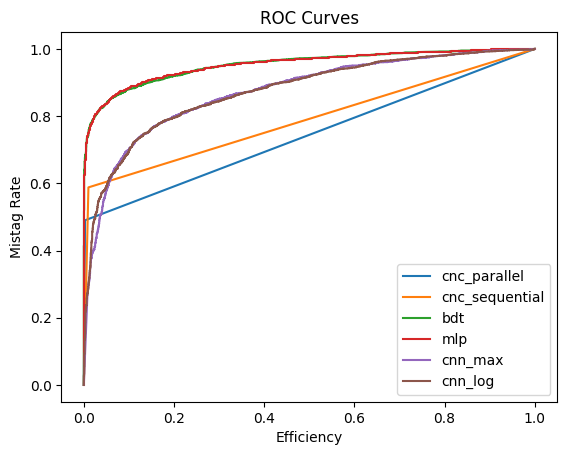

In [30]:
for name, metrics in results.items():
    fpr = metrics["fpr"]
    tpr = metrics["tpr"]
    plt.plot(fpr, tpr, label=f"{name}")

plt.title("ROC Curves")
plt.xlabel("Efficiency")
plt.ylabel("Mistag Rate")
plt.legend()
plt.show()

## Plot the cuts found automatically

In [31]:
ds = load_dataset("./data/wjj_vs_qcd_set.ds")

x_train, y_train = ds.train.samples, ds.train.targets
x_test, y_test = ds.test.samples, ds.test.targets

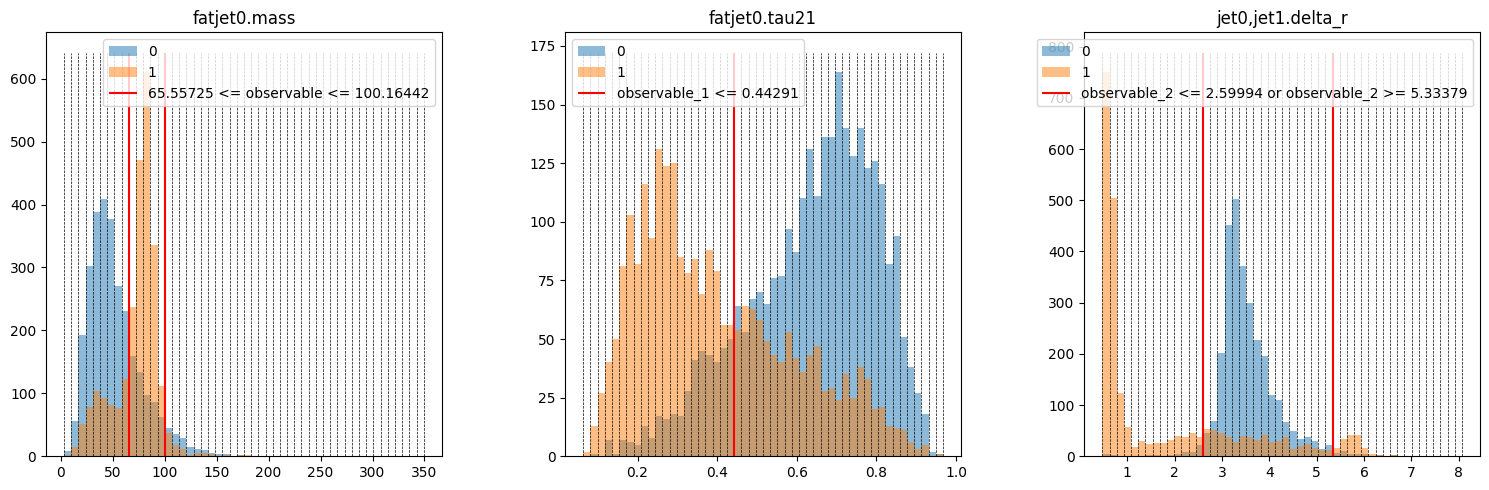

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(x_train.shape[1]):
    layer = cnc1.cut_layers[i]

    observable = ds.feature_names[i]
    bin_edges = np.linspace(x_train[:, i].min(), x_train[:, i].max(), cnc1.n_bins + 1)

    axs[i].hist(x_test[:, i][y_test == 0], bins=bin_edges, alpha=0.5, label="0")
    axs[i].hist(x_test[:, i][y_test == 1], bins=bin_edges, alpha=0.5, label="1")

    y_min, y_max = axs[i].get_ylim()
    axs[i].vlines(bin_edges, y_min, y_max, color="k", ls="dashed", lw=0.5)

    if layer.case == 0:
        axs[i].vlines(layer.cut_left, y_min, y_max, color="r", label=layer.cut)
    elif layer.case == 1:
        axs[i].vlines(layer.cut_right, y_min, y_max, color="r", label=layer.cut)
    elif layer.case == 2:
        axs[i].vlines(layer.cut_left, y_min, y_max, color="r", label=layer.cut)
        axs[i].vlines(layer.cut_right, y_min, y_max, color="r")
    else:
        axs[i].vlines(layer.cut_left, y_min, y_max, color="r", label=layer.cut)
        axs[i].vlines(layer.cut_right, y_min, y_max, color="r")

    axs[i].set_title(f"{observable}")
    axs[i].legend()

plt.tight_layout()
plt.show()

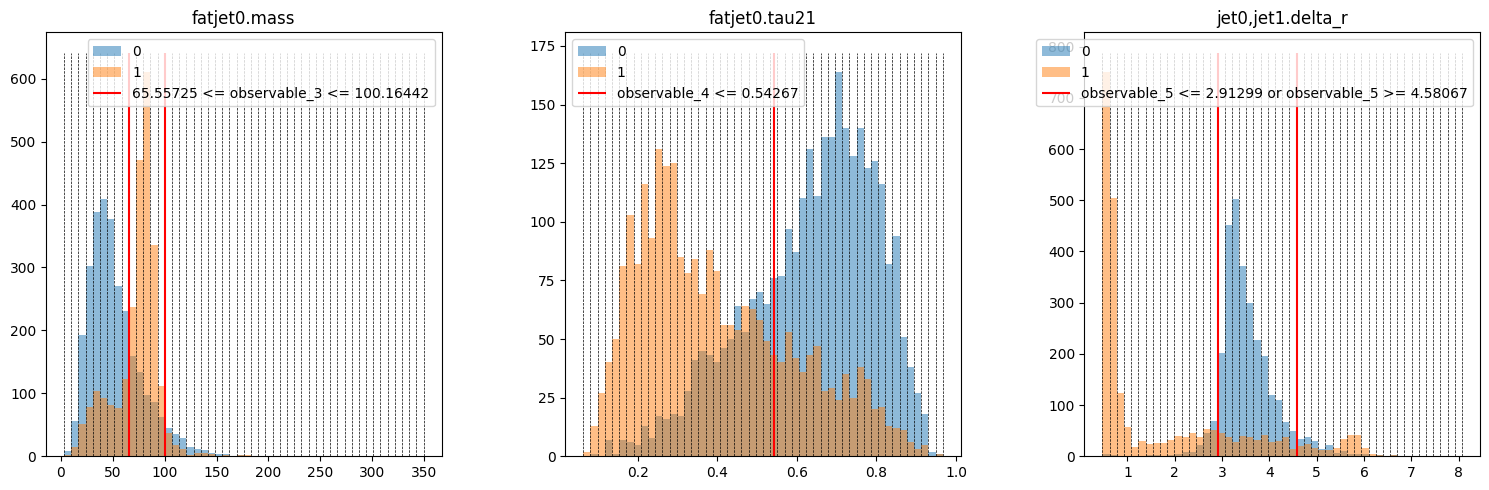

In [33]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(x_train.shape[1]):
    layer = cnc2.cut_layers[i]

    observable = ds.feature_names[i]
    bin_edges = np.linspace(x_train[:, i].min(), x_train[:, i].max(), cnc2.n_bins + 1)

    axs[i].hist(x_test[:, i][y_test == 0], bins=bin_edges, alpha=0.5, label="0")
    axs[i].hist(x_test[:, i][y_test == 1], bins=bin_edges, alpha=0.5, label="1")

    y_min, y_max = axs[i].get_ylim()
    axs[i].vlines(bin_edges, y_min, y_max, color="k", ls="dashed", lw=0.5)

    if layer.case == 0:
        axs[i].vlines(layer.cut_left, y_min, y_max, color="r", label=layer.cut)
    elif layer.case == 1:
        axs[i].vlines(layer.cut_right, y_min, y_max, color="r", label=layer.cut)
    elif layer.case == 2:
        axs[i].vlines(layer.cut_left, y_min, y_max, color="r", label=layer.cut)
        axs[i].vlines(layer.cut_right, y_min, y_max, color="r")
    else:
        axs[i].vlines(layer.cut_left, y_min, y_max, color="r", label=layer.cut)
        axs[i].vlines(layer.cut_right, y_min, y_max, color="r")

    axs[i].set_title(f"{observable}")
    axs[i].legend()

plt.tight_layout()
plt.show()

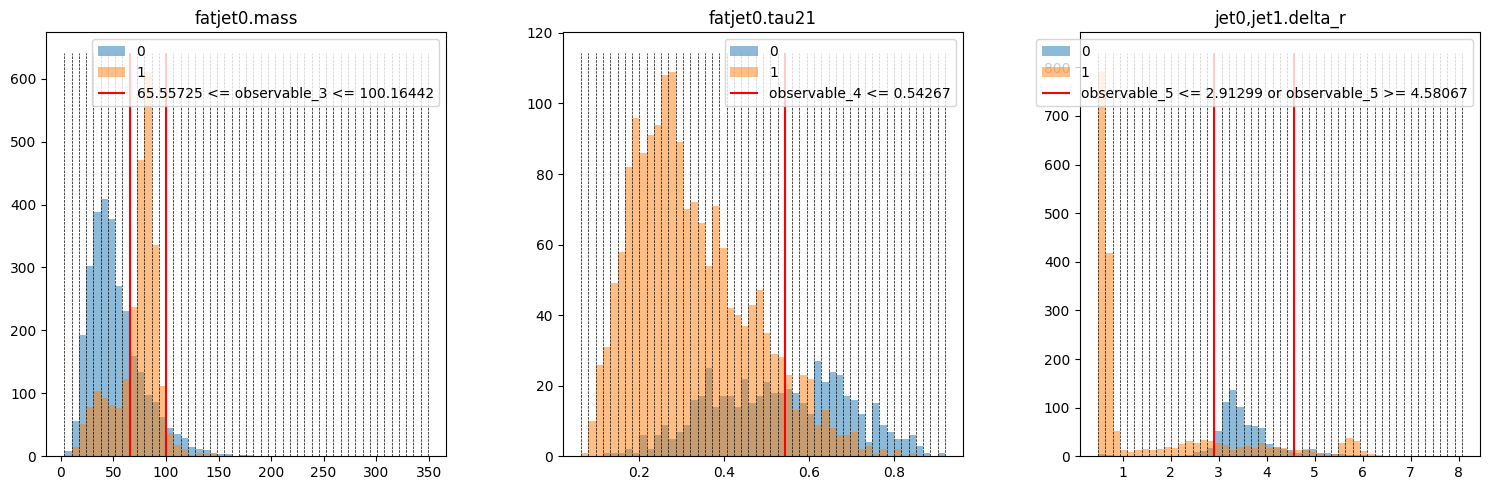

In [34]:
cut_layers = cnc2.cut_layers
mask_train = ops.squeeze(ops.where(ops.ones(x_train.shape[0]) == 1))
mask_test = ops.squeeze(ops.where(ops.ones(x_test.shape[0]) == 1))

plt.figure(figsize=(15, 5))
for i in range(x_train.shape[1]):
    plt.subplot(1, 3, i + 1)
    layer = cut_layers[i]

    masked_x_train = ops.convert_to_numpy(ops.take(x_train[:, i], mask_train))
    masked_y_train = ops.convert_to_numpy(ops.take(y_train, mask_train))
    bin_edges = np.linspace(masked_x_train.min(), masked_x_train.max(), 50 + 1)
    mask_train = ops.squeeze(ops.where(cut_layers[i].apply_cut(x_train) == 1))

    masked_x_test = ops.convert_to_numpy(ops.take(x_test[:, i], mask_test))
    masked_y_test = ops.convert_to_numpy(ops.take(y_test, mask_test))
    mask_test = ops.squeeze(ops.where(cut_layers[i].apply_cut(x_test) == 1))

    plt.hist(masked_x_test[masked_y_test == 0], bins=bin_edges, alpha=0.5, label="0")
    plt.hist(masked_x_test[masked_y_test == 1], bins=bin_edges, alpha=0.5, label="1")

    y_min, y_max = plt.gca().get_ylim()
    plt.vlines(bin_edges, y_min, y_max, color="k", ls="dashed", lw=0.5)

    if layer.case == 0:
        plt.vlines(layer.cut_left, y_min, y_max, color="r", label=layer.cut)
    elif layer.case == 1:
        plt.vlines(layer.cut_left, y_min, y_max, color="r", label=layer.cut)
    elif layer.case == 2:
        plt.vlines(layer.cut_left, y_min, y_max, color="r", label=layer.cut)
        plt.vlines(layer.cut_right, y_min, y_max, color="r")
    else:
        plt.vlines(layer.cut_left, y_min, y_max, color="r", label=layer.cut)
        plt.vlines(layer.cut_right, y_min, y_max, color="r")

    plt.title(ds.feature_names[i])
    plt.legend()
plt.tight_layout()
plt.show()

In [35]:
cnc1.save("./checkpoints/cnc_parallel.keras")
cnc2.save("./checkpoints/cnc_sequential.keras")
bdt.save("./checkpoints/bdt.pickle")
mlp.save("./checkpoints/mlp.keras")
cnn1.save("./checkpoints/cnn1.keras")
cnn2.save("./checkpoints/cnn2.keras")

In [36]:
loaded_cnc1 = load_approach("./checkpoints/cnc_parallel.keras")
loaded_cnc2 = load_approach("./checkpoints/cnc_sequential.keras")
loaded_bdt = load_approach("./checkpoints/bdt.pickle")
loaded_mlp = load_approach("./checkpoints/mlp.keras")
loaded_cnn1 = load_approach("./checkpoints/cnn1.keras")
loaded_cnn2 = load_approach("./checkpoints/cnn2.keras")